In [3]:
import pandas as pd
import numpy as np
import os
import sys

from utils import *

#plotting
from matplotlib import pyplot as plt
%matplotlib inline

#processing
from scipy.signal import resample

#ml
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import mlflow
import mlflow.tensorflow

### Schema

0. x coordinate
1. y coordinate
2. timestamp
3. pen-up
4. azimuth angle
5. altitude angle
6. Pressure

In [4]:
features=['x','y','pen_up','pressure']
#features=['x','y']

doc_path = "/data/elekin/doc"
results_path = "/data/elekin/data/results/handwriting"

day="20220906"

In [5]:
df = pd.read_csv(os.path.join(results_path,"biodarw_{}.csv".format(day))).set_index('subject_id')[features]
df.sample(5)

,x,y,pen_up,pressure
subject_id,,,,
C103_1,5250,2700,0,0
C08,4573,2627,1,1167
T002_1,4769,3361,1,2048
C101_1,4924,2544,1,1538
C04_1,4448,2469,1,1271


In [6]:
df.shape

(135499, 4)

In [ ]:
df_w = make_sliding(df[['x','y']], N=50)

In [ ]:
df_w.shape

In [7]:
labels = pd.read_csv(os.path.join(results_path,"level_{}.csv".format(day))).set_index('subject_id')
labels.sample(10)

,level
subject_id,
C107_1,0
T005,2
C107_2,0
T018,1
T023_2,2
T012_2,1
T025,1
T008,1
C06_1,0


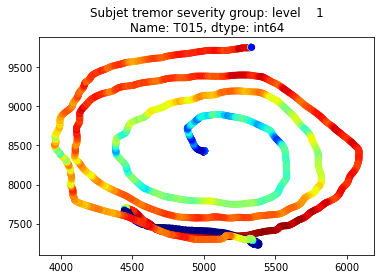

In [8]:
idx = 'T015'
label = labels.loc[idx]
plt.scatter(df.loc[idx]['x'], df.loc[idx]['y'], c=df.loc[idx]['pressure'], cmap='jet')
_=plt.title("Subjet tremor severity group: {}".format(label))

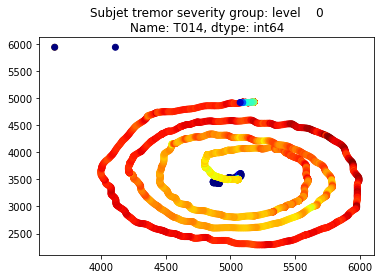

In [9]:
idx = 'T014'
label = labels.loc[idx]
plt.scatter(df.loc[idx]['x'], df.loc[idx]['y'], c=df.loc[idx]['pressure'], cmap='jet')
_=plt.title("Subjet tremor severity group: {}".format(label))

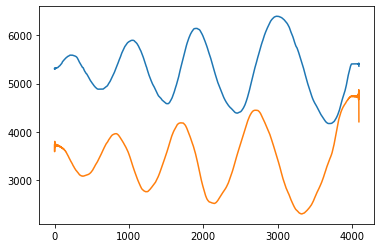

In [18]:
df_rs = df[['x','y']].groupby('subject_id').apply(resample, 4096)
plt.plot(df_rs['C01_1'])

In [9]:
np.array(df_rs.values.tolist()).shape

(53, 4096, 2)

In [18]:
y = labels.values

In [23]:
X = np.array(df_rs.values.tolist())
y = labels.values.ravel()
seed = 38
n_outputs = 3
mini_batch_size=53

n_timesteps = np.array(X).shape[1]
n_features = np.array(X).shape[2]

data_size = np.array(X).shape[0]
train_split = 0.67
test_split = 0.33 
train_size = int(train_split * data_size)
test_size = int(test_split * data_size)

shuffle_buffer = data_size
steps_per_epoch = round(data_size/mini_batch_size)


AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time

URI = "http://mlflow_server:5001"

mlflow.set_tracking_uri(URI)
mlflow.set_experiment('/archimedes-dl')

<Experiment: artifact_location='/mlruns/1', experiment_id='1', lifecycle_stage='active', name='/archimedes-dl', tags={}>

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y,n_outputs)))
full_dataset = dataset.shuffle(shuffle_buffer, seed=seed)
train_dataset = full_dataset.take(train_size).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = full_dataset.skip(train_size).batch(mini_batch_size).prefetch(AUTOTUNE).cache()

# for feat, targ in train_dataset.shuffle(shuffle_buffer):
# #         print ('Features: {0}'.format(feat, targ))
#     print ('Target train: {1}'.format(feat, targ))
    
# for feat, targ in test_dataset.shuffle(shuffle_buffer):
# #         print ('Features test: {}, Target test: {}'.format(feat, targ))
#         print ('Target test: {1}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

1 train batches and 1 test batches of 53 mini batch size and 1 steps per epoch


In [25]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2e2, min_delta=1e-3),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1e3):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=True)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1e3):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [28]:
size_histories = {}
run = 'lstm/tiny'
mlflow.tensorflow.autolog(every_n_iter=1)
do = 0.20
units = 128

mlflow.start_run(run_name=run)
mlflow.log_param("seed", seed)
mlflow.log_param("drop_out", do)
mlflow.log_param("mini_batch_size", mini_batch_size)
mlflow.log_param("train_split", train_split)
mlflow.log_param("test_split", test_split)
mlflow.log_param("lstm_units", units)
mlflow.log_param("features", features)

In [33]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units, activation=tf.nn.tanh, return_sequences=True, input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Dropout(do))
model.add(tf.keras.layers.LSTM(units, activation=tf.nn.tanh, return_sequences=True ))
model.add(tf.keras.layers.Dropout(do ))
model.add(tf.keras.layers.LSTM(units, activation=tf.nn.tanh, return_sequences=False ))
model.add(tf.keras.layers.Dropout(do))
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu, name='hidden_layer'))
model.add(tf.keras.layers.Dense(n_outputs, activation=tf.nn.sigmoid, name='output'))

In [34]:
size_histories[run] = compile_and_fit(model, train_dataset, test_dataset,
                                              run, 
                                              optimizer=get_optimizer(),
#                                               optimizer=tf.keras.optimizers.Adam(0.001), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=1000)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories[run].history["accuracy"]))
print('test acc:', max(size_histories[run].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4096, 128)         67072     
                                                                 
 dropout (Dropout)           (None, 4096, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 4096, 128)         131584    
                                                                 
 dropout_1 (Dropout)         (None, 4096, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 hidden_layer (Dense)        (None, 100)               1

KeyboardInterrupt: 

In [17]:
mlflow.end_run()